# Regression Project



In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.api import abline_plot
from scipy import stats
from statsmodels import graphics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error



In [2]:
# importing data
# upload data or mount drive
filename = ""
df = pd.read_csv(filename)

# New Section

<AxesSubplot:>

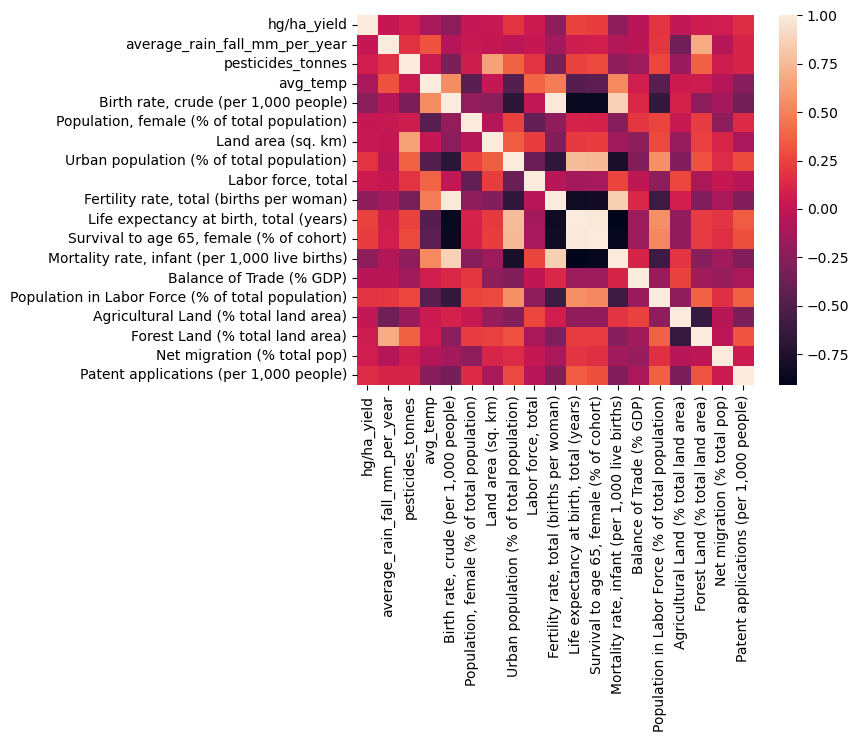

In [3]:
# !ls
# import os
# os.getcwd()
# os.setwd('')
# df.columns
corr_matrix = df.drop(['Area', 'Item', 'Year'], axis=1).corr()
sns.heatmap(corr_matrix)

## Defining Helper Functions

In [4]:
df['Year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013], dtype=int64)

In [5]:
def data_split(df):
    # will have to remove 'Sudan' from test and val as it is not in train
    df = df[df['Area'] != 'Sudan']
    train_data = df[df['Year']<= 2010]
    val_data = df[(df['Year'] >= 2011) & (df['Year']<= 2012)]
    test_data = df[df['Year'] == 2013]
    return train_data, val_data, test_data

In [6]:
def add_onehot(df,column):
    df_new = df.copy()
    one_hot = pd.get_dummies(df_new[column])
    df_new = df_new.drop(column,axis = 1)
    df_new = df_new.join(one_hot)
    return df_new

In [7]:
class MLR():
    def __init__(self,df,significance):
        self.X = df.drop('hg/ha_yield', axis=1)
        self.y = df['hg/ha_yield']
        self.X = sm.add_constant(self.X)
        self.model = sm.OLS(self.y, self.X).fit()
        self.significance = significance
    def modelsummary(self):
        return(self.model.summary())
    def rsquared(self):
        return self.model.rsquared
    def VIF(self):
        vif = [variance_inflation_factor(self.X.values, i) for i in range(self.X.shape[1])]
        vif = np.array(vif)
        vif = np.sort(vif)
        self.vif_vals = vif
    def cook(self):
        influence = self.model.get_influence()
        cooks_d, pvals = influence.cooks_distance
        self.cooks_dist = cooks_d, pvals
    def DW(self):
        durbin_watson = sm.stats.stattools.durbin_watson(self.model.resid)
        return(durbin_watson)
    def printall(self):
        print(r"""
__________________________________________________________________________________
  __  __           _      _    _____                                            
 |  \/  |         | |    | |  / ____|                                           
 | \  / | ___   __| | ___| | | (___  _   _ _ __ ___  _ __ ___   __ _ _ __ _   _ 
 | |\/| |/ _ \ / _` |/ _ \ |  \___ \| | | | '_ ` _ \| '_ ` _ \ / _` | '__| | | |
 | |  | | (_) | (_| |  __/ |  ____) | |_| | | | | | | | | | | | (_| | |  | |_| |
 |_|  |_|\___/ \__,_|\___|_| |_____/ \__,_|_| |_| |_|_| |_| |_|\__,_|_|   \__, |
                                                                           __/ |
                                                                          |___/      
_________________________________________________________________________________      
        """)
        print(self.modelsummary())
        print(r"""  
__________________________________________________________________________   
  __  __           _      _                        _           _       _ 
 |  \/  |         | |    | |     /\               | |         (_)     | |
 | \  / | ___   __| | ___| |    /  \   _ __   __ _| |_   _ ___ _ ___  | |
 | |\/| |/ _ \ / _` |/ _ \ |   / /\ \ | '_ \ / _` | | | | / __| / __| | |
 | |  | | (_) | (_| |  __/ |  / ____ \| | | | (_| | | |_| \__ \ \__ \ |_|
 |_|  |_|\___/ \__,_|\___|_| /_/    \_\_| |_|\__,_|_|\__, |___/_|___/ (_)
                                                      __/ |              
                                                     |___/               
__________________________________________________________________________   
""")
        # R-squared
        rsq = self.rsquared()
        print("R Squared value: ", rsq)
        print("__________")
        # VIF
        if not hasattr(full_reg, 'vif'):
          self.VIF()
        
        vif = self.vif_vals
        vif = vif[::-1]
        vif = vif[0:5]
        print("Highest 5 VIF Values: ", vif)
        if vif[0] > max(10,1/(1-rsq)):
            print("Since VIF is too high, multicollinearity is problematic.")
        else:
            print("VIF is not too high, multicollinearity is not problematic.")
        print("__________")
        # COOK
        
        if not hasattr(full_reg, 'cooks_dist'):
          self.cook()
        
        cook,pval = self.cooks_dist
        # print(cook)
        cook = np.sort(cook)
        cook = cook[::-1]
        cook = cook[0:5]
        print("Highest 5 Cook's Distances: ", cook)
        if cook[0] > 4/self.X.shape[0] or cook[0] > 1:
            print("Some Cook's Distances may be a bit high and should be investigated.")
        else:
            print("Cook's Distances are not an issue.")

        print("__________")
        # DW
        lower_bound = 1.53
        upper_bound = 1.47
        durbin_watson_statistic = self.DW()

        # Print the Durbin-Watson test statistic and critical values
        print(f"Durbin-Watson test statistic: {durbin_watson_statistic}")
        print(f"Lower bound: {lower_bound}")
        print(f"Upper bound: {upper_bound}")
        if durbin_watson_statistic > lower_bound and durbin_watson_statistic < upper_bound:
            print("Model passes the Durbin-Watson test (no autocorrelation)")
        else:
            print("Model fails the Durbin-Watson test (autocorrelation detected)")

## Linear Regression on the full set of data

In [8]:
train_data, val_data, test_data = data_split(df)
frtrain_data = add_onehot(train_data,"Area")
frtrain_data = add_onehot(frtrain_data,"Item")
full_reg = MLR(frtrain_data,0.05)
full_reg.printall()


__________________________________________________________________________________
  __  __           _      _    _____                                            
 |  \/  |         | |    | |  / ____|                                           
 | \  / | ___   __| | ___| | | (___  _   _ _ __ ___  _ __ ___   __ _ _ __ _   _ 
 | |\/| |/ _ \ / _` |/ _ \ |  \___ \| | | | '_ ` _ \| '_ ` _ \ / _` | '__| | | |
 | |  | | (_) | (_| |  __/ |  ____) | |_| | | | | | | | | | | | (_| | |  | |_| |
 |_|  |_|\___/ \__,_|\___|_| |_____/ \__,_|_| |_| |_|_| |_| |_|\__,_|_|   \__, |
                                                                           __/ |
                                                                          |___/      
_________________________________________________________________________________      
        
                            OLS Regression Results                            
Dep. Variable:            hg/ha_yield   R-squared:                       0.758
Model:  

c:\Users\R\anaconda3\envs\bbc\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Highest 5 VIF Values:  [inf inf inf inf inf]
Since VIF is too high, multicollinearity is problematic.
__________
Highest 5 Cook's Distances:  [0.00659183 0.00636563 0.00546848 0.00457081 0.0043098 ]
Some Cook's Distances may be a bit high and should be investigated.
__________
Durbin-Watson test statistic: 1.2055532731376943
Lower bound: 1.53
Upper bound: 1.47
Model fails the Durbin-Watson test (autocorrelation detected)


In [9]:
# outlier analysis
# 'cooks' in full_reg 
# hasattr(full_reg, 'cooks_dist')
cook,pval = full_reg.cooks_dist

len(cook[cook > 4/full_reg.X.shape[0]]) # 1413 outliers (might need to see which ones are bad) 

1413

In [10]:
# Finding insignificant vars
full_reg.model.pvalues[full_reg.model.pvalues > 0.05]

avg_temp                                             0.961060
Birth rate, crude (per 1,000 people)                 0.178199
Population, female (% of total population)           0.240250
Urban population (% of total population)             0.671743
Labor force, total                                   0.206857
Fertility rate, total (births per woman)             0.113701
Life expectancy at birth, total (years)              0.545892
Survival to age 65, female (% of cohort)             0.960773
Mortality rate, infant (per 1,000 live births)       0.629911
Balance of Trade (% GDP)                             0.921060
Population in Labor Force (% of total population)    0.158414
Agricultural Land (% total land area)                0.056983
Net migration (% total pop)                          0.758410
Armenia                                              0.108380
Azerbaijan                                           0.190437
Bahrain                                              0.081321
Belarus 

In [11]:
significant_coef = full_reg.model.params.index[full_reg.model.pvalues < 0.05]

In [12]:
significant_coef

Index(['const', 'Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes',
       'Land area (sq. km)', 'Forest Land (% total land area)',
       'Patent applications (per 1,000 people)', 'Albania', 'Algeria',
       'Angola', 'Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Brazil', 'Canada', 'Central African Republic', 'Croatia', 'Denmark',
       'El Salvador', 'France', 'Germany', 'Greece', 'Guatemala', 'Honduras',
       'India', 'Indonesia', 'Ireland', 'Italy', 'Jamaica', 'Kazakhstan',
       'Lebanon', 'Libya', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania',
       'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Niger', 'Norway', 'Pakistan', 'Peru',
       'Qatar', 'Saudi Arabia', 'Slovenia', 'South Africa', 'Sri Lanka',
       'Suriname', 'Sweden', 'Switzerland', 'Tajikistan', 'United Kingdom',
       'Uruguay', 'Zambia', 'Cassava', 'Maize', 'Plantains and others',
       'Potatoes', 'Rice, padd

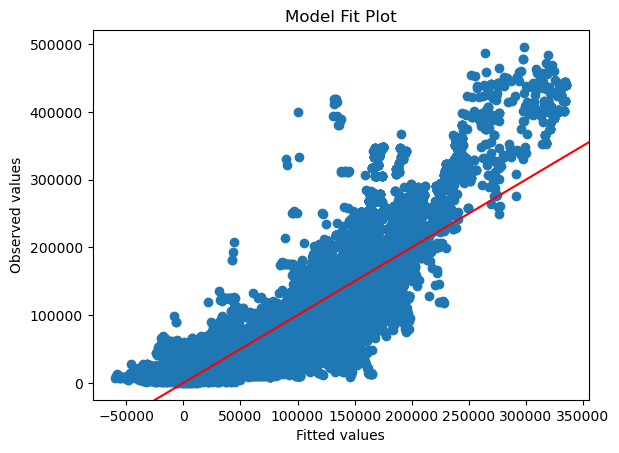

In [13]:
yhat = full_reg.model.fittedvalues

fig, ax = plt.subplots()
ax.scatter(yhat, full_reg.y)
line_fit = sm.OLS(full_reg.y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax, color = 'r')


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

Text(0.5, 0, 'Fitted values')

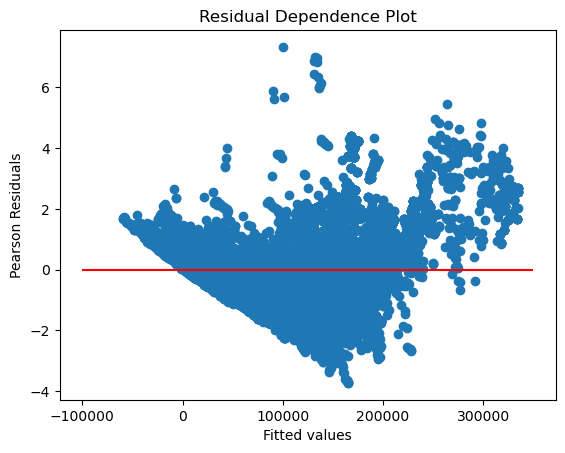

In [14]:

fig, ax = plt.subplots()

ax.scatter(yhat, full_reg.model.resid_pearson)
ax.hlines(0, -100000, 350000, colors='r')
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

Text(0.5, 0, 'Avg rainfall')

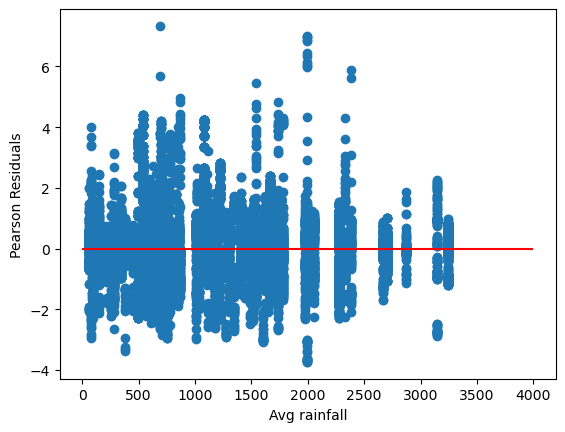

In [15]:
fig, ax = plt.subplots()

ax.scatter(full_reg.X['average_rain_fall_mm_per_year'], full_reg.model.resid_pearson)
ax.hlines(0, 0, 4000, colors='r')
#ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Avg rainfall')

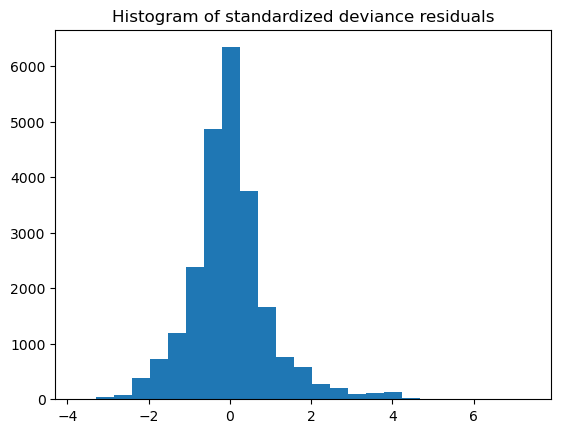

In [16]:
fig, ax = plt.subplots()

resid = full_reg.model.resid_pearson.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

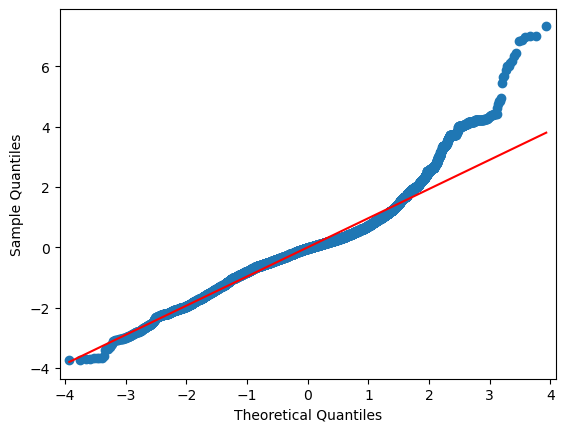

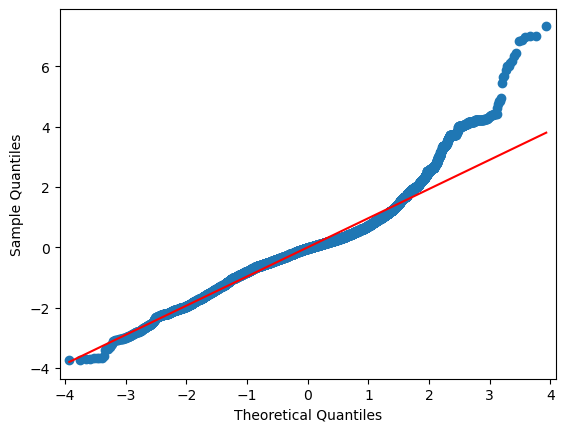

In [17]:
# qq plots
graphics.gofplots.qqplot(resid, line='r')

In [18]:
def model_rmse(model, test_data):
  frtest_data = add_onehot(test_data,"Area")
  frtest_data = add_onehot(frtest_data,"Item")
  y_test = frtest_data['hg/ha_yield']
  frtest_data = frtest_data.drop('hg/ha_yield', axis=1)
  frtest_data = sm.add_constant(frtest_data, has_constant='add')

  y_pred = model.predict(frtest_data)

  #evaluate RMSE
  qwe = rmse(y_test, y_pred)

  #evaluate MAPE
  qwe2 = mean_absolute_percentage_error(y_test, y_pred)
  
  return qwe, qwe2



# model_rmse(full_reg.model, test_data)
model_rmse(full_reg.model, val_data)

(50866.343857503176, 0.8312925825184324)

In [19]:
print(df.columns)

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp', 'Birth rate, crude (per 1,000 people)',
       'Population, female (% of total population)', 'Land area (sq. km)',
       'Urban population (% of total population)', 'Labor force, total',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Survival to age 65, female (% of cohort)',
       'Mortality rate, infant (per 1,000 live births)',
       'Balance of Trade (% GDP)',
       'Population in Labor Force (% of total population)',
       'Agricultural Land (% total land area)',
       'Forest Land (% total land area)', 'Net migration (% total pop)',
       'Patent applications (per 1,000 people)'],
      dtype='object')


In [20]:
selected_vars = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes',
       'Land area (sq. km)', 'Forest Land (% total land area)',
       'Patent applications (per 1,000 people)', 'Albania', 'Algeria',
       'Angola', 'Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Brazil', 'Canada', 'Central African Republic', 'Croatia', 'Denmark',
       'El Salvador', 'France', 'Germany', 'Greece', 'Guatemala', 'Honduras',
       'India', 'Indonesia', 'Ireland', 'Italy', 'Jamaica', 'Kazakhstan',
       'Lebanon', 'Libya', 'Madagascar', 'Malaysia', 'Mali', 'Mauritania',
       'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'Nepal', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Niger', 'Norway', 'Pakistan', 'Peru',
       'Qatar', 'Saudi Arabia', 'Slovenia', 'South Africa', 'Sri Lanka',
       'Suriname', 'Sweden', 'Switzerland', 'Tajikistan', 'United Kingdom',
       'Uruguay', 'Zambia', 'Cassava', 'Maize', 'Plantains and others',
       'Potatoes', 'Rice, paddy', 'Sorghum', 'Soybeans', 'Sweet potatoes',
       'Wheat', 'Yams']

reduced_X = frtrain_data[selected_vars]

In [21]:
full_reg.X.shape

(23608, 127)

In [22]:
reduced_X.shape

(23608, 71)

In [23]:
full_reg.y.shape

(23608,)

In [24]:
model1 = sm.OLS(full_reg.y, reduced_X).fit() # reduced regression model

# model_rmse(model1, test_data)
#model_rmse(model1, val_data)

In [25]:
# model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hg/ha_yield   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     998.7
Date:                Sun, 23 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:23:13   Log-Likelihood:            -2.8455e+05
No. Observations:               23608   AIC:                         5.692e+05
Df Residuals:                   23537   BIC:                         5.698e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Year                                    1033.5211     45.327     22.801      0.000     944.677    1122.366
average_rain_fall_mm_per_year            -23.3414      0.954    -24.472      0.000     -25.211     -21.472
pesticides_tonnes                          0.0549      0.009      5.777      0.000       0.036       0.073
Land area (sq. km)                         0.0523      0.002     24.057      0.000       0.048       0.057
Forest Land (% total land area)          383.0555     36.185     10.586      0.000     312.130     453.981
Patent applications (per 1,000 people)  2.459e+04    741.195     33.176      0.000    2.31e+04     2.6e+04
Albania                                 3.887e+04   4576.054      8.494      0.000    2.99e+04    4.78e+04
Algeria                                -1.073e+05   6413.862    -16.725      0.000    -1.2e+05   -9.47e+04
Angola                                 -8.908e+04   4323.933    -20.602      0.000   -9.76e+04   -8.06e+04
Argentina                              -9.902e+04   5863.711    -16.887      0.000   -1.11e+05   -8.75e+04
Australia                              -3.276e+05   1.62e+04    -20.219      0.000   -3.59e+05   -2.96e+05
Austria                                 7.165e+04   4706.007     15.225      0.000    6.24e+04    8.09e+04
Bangladesh                              5.608e+04   3361.080     16.686      0.000    4.95e+04    6.27e+04
Belgium                                 1.608e+05   7645.885     21.035      0.000    1.46e+05    1.76e+05
Brazil                                 -4.147e+05   1.72e+04    -24.065      0.000   -4.48e+05   -3.81e+05
Canada                                 -4.536e+05   1.91e+04    -23.790      0.000   -4.91e+05   -4.16e+05
Central African Republic               -6.444e+04   3628.242    -17.760      0.000   -7.15e+04   -5.73e+04
Croatia                                 3.272e+04   4458.303      7.339      0.000     2.4e+04    4.15e+04
Denmark                                 1.457e+05   6572.171     22.164      0.000    1.33e+05    1.59e+05
El Salvador                             5.529e+04   3472.684     15.921      0.000    4.85e+04    6.21e+04
France                                  5.476e+04   3931.844     13.927      0.000    4.71e+04    6.25e+04
Germany                                 7.174e+04   2817.575     25.463      0.000    6.62e+04    7.73e+04
Greece                                  4.827e+04   3591.096     13.443      0.000    4.12e+04    5.53e+04
Guatemala                                5.23e+04   3296.298     15.867      0.000    4.58e+04    5.88e+04
Honduras                                 1.21e+04   3322.799      3.640      0.000    5583.722    1.86e+04
India                                  -1.133e+05   5787.348    -19.572      0.000   -1

In [1]:
from scipy.stats import f

# Define the two groups' residual degrees of freedom and variance
df_resid_1 = 23484
df_resid_2 = 23537
df1 = 123
df2 = 70
var1 = df_resid_1 / df1
var2 = df_resid_2 / df2

# Calculate the F-statistic and p-value
F = var1 / var2
p_value = f.cdf(F, df1, df2)

# Print the results
print("F-statistic: ", F)
print("p-value: ", p_value)

F-statistic:  0.5678241937706797
p-value:  0.0030893943071031264


In [26]:
# model_rmse(full_reg.model1, val_data[])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (890447061.py, line 1)

In [ ]:
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_pacf

# # Calculate the residuals
# residuals1 = model1.resid

# # Check for autocorrelation in the residuals
# dw = sm.stats.stattools.durbin_watson(residuals1)
# if dw < 1.5 or dw > 2.5:
#     for col in reduced_X.columns:
#         pacf_vals = sm.tsa.stattools.pacf(reduced_X[col])
#         if max(abs(pacf_vals[1:])) > 0.5: # check for significant autocorrelation
#             plot_pacf(reduced_X[col], lags=20)

In [ ]:
model2 = sm.OLS(full_reg.y, full_reg.X).fit_regularized() # need to tune the hyperparams

# model_rmse(model2, test_data)
model_rmse(model2, val_data)

51289.00671045709


In [ ]:
alpha_values = [.0001, .001, .005, .01, .05, 0.1, 0.5, 1.0, 5.0]  # list of alpha values to try
best_alpha = None
best_score = float('inf')

for alpha in alpha_values:
    model = sm.OLS(full_reg.y, full_reg.X).fit_regularized(method='elastic_net', alpha=alpha, L1_wt=0.0)
    frval_data = add_onehot(val_data,"Area")
    frval_data = add_onehot(frval_data,"Item")
    y_val = frval_data['hg/ha_yield']
    frval_data = frval_data.drop('hg/ha_yield', axis=1)
    frval_data = sm.add_constant(frval_data, has_constant='add')
    y_pred = model.predict(frval_data)

    # evaluate RMSE
    score = rmse(y_val, y_pred)
    print(f"Alpha={alpha}, Score={score}")
    
    if score < best_score:  # update best alpha if current score is better
        best_alpha = alpha
        best_score = score

print(f"Best alpha={best_alpha}, Best Score={best_score}")

Alpha=0.0001, Score=51054.86014230925
Alpha=0.001, Score=51230.787804471496
Alpha=0.005, Score=52270.53058906722
Alpha=0.01, Score=53451.497809377535
Alpha=0.05, Score=60618.847402191444
Alpha=0.1, Score=66713.12199780432
Alpha=0.5, Score=82782.91995666796
Alpha=1.0, Score=87321.70185245025
Alpha=5.0, Score=92033.04926631968
Best alpha=0.0001, Best Score=51054.86014230925


In [31]:
# RF model
from sklearn.ensemble import RandomForestRegressor

frtest_data = add_onehot(val_data,"Area")
frtest_data = add_onehot(frtest_data,"Item")
y_test = frtest_data['hg/ha_yield']
frtest_data = frtest_data.drop('hg/ha_yield', axis=1)
frtest_data = sm.add_constant(frtest_data, has_constant='add')

min_samples_split = int(0.05*full_reg.X.shape[0])

# create the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split=min_samples_split)

# fit the model on the training data
rf.fit(full_reg.X, full_reg.y)

# make predictions on the test data
y_pred = rf.predict(frtest_data)

qwe = rmse(y_test, y_pred)
print(qwe)

51026.082041669106


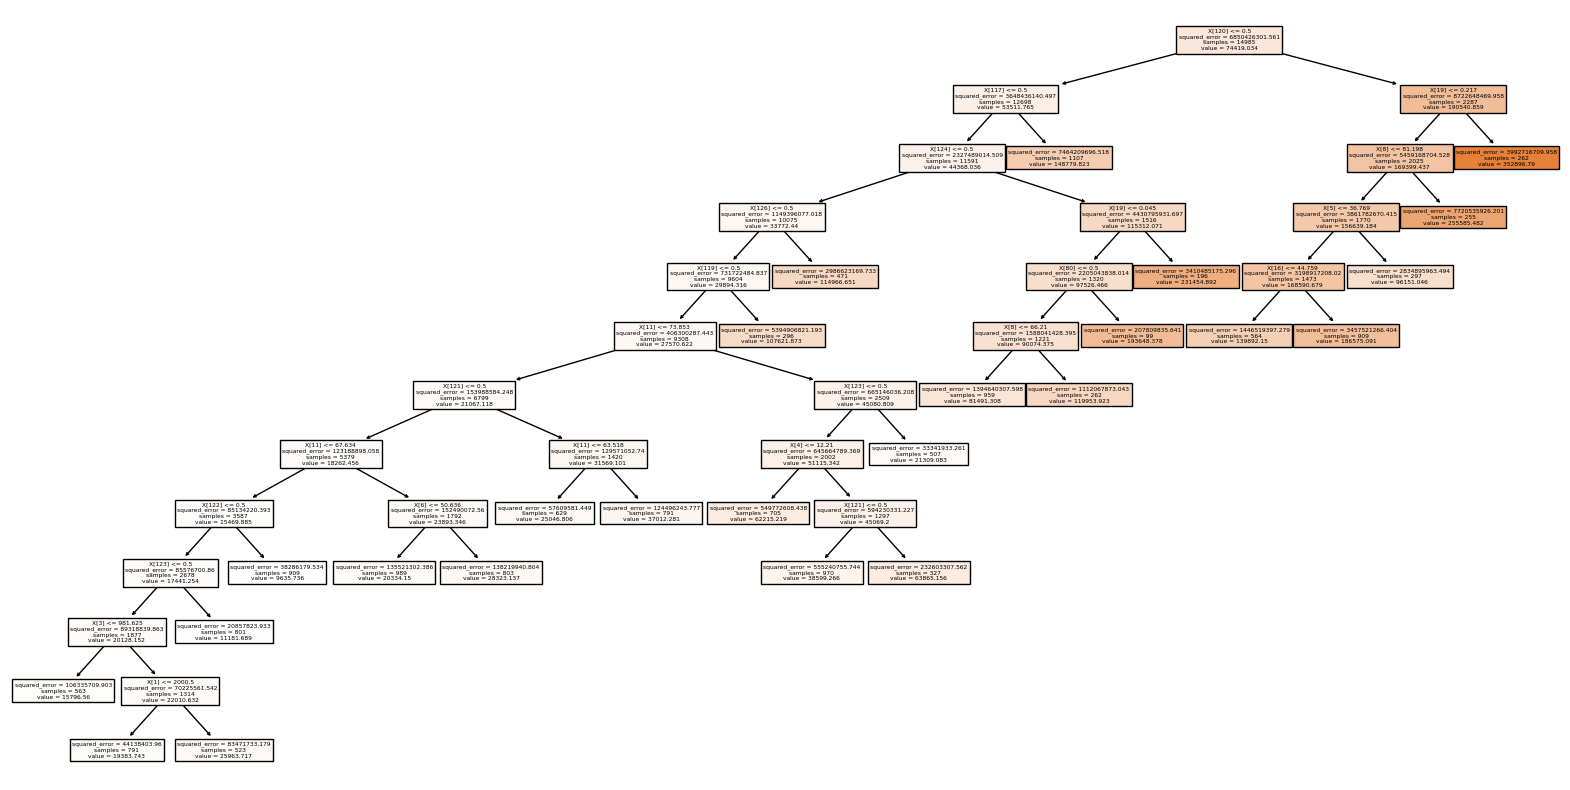

In [32]:
from sklearn.datasets import make_regression
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# plot the first decision tree in the random forest
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True)
plt.show()

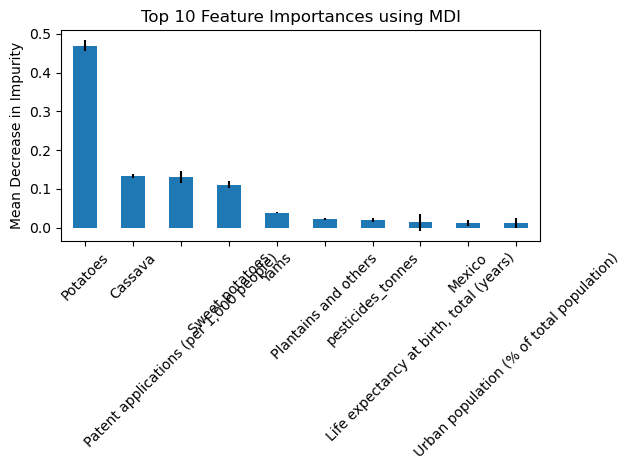

In [83]:
# import pandas as pd

# importances = rf.feature_importances_
# forest_importances = pd.Series(importances, index=full_reg.X.columns.values.tolist())
# std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# importances = rf.feature_importances_
# forest_importances = pd.Series(importances, index=full_reg.X.columns.values.tolist())
# std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# # Sort the feature importances in descending order and take the top 10
# top_importances = forest_importances.sort_values(ascending=False).head(10)

# fig, ax = plt.subplots()
# top_importances.plot.bar(yerr=std[top_importances.index], ax=ax)
# ax.set_title("Top 10 feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=full_reg.X.columns.values.tolist())
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Sort the feature importances in descending order and select the top 10
top_10_indices = forest_importances.sort_values(ascending=False).head(10).index
top_10_forest_importances = forest_importances[top_10_indices]
top_10_std = std[sorted(range(len(list(forest_importances))), key=lambda i: list(forest_importances)[i])[-10:]]

# Plot the top 10 feature importances
fig, ax = plt.subplots()
top_10_forest_importances.plot.bar(yerr=top_10_std, ax=ax)
ax.set_title("Top 10 Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xticklabels(top_10_indices, rotation=45) # set custom x-axis labels
fig.tight_layout()
plt.show()

In [79]:
['Potatoes', 'Cassava', 'Patent applications',
       'Sweet potatoes', 'Yams', 'Plantains & More', 'Pesticides Tons',
       'Life expectancy at birth', 'Mexico',
       'Urban population %']

Index(['Potatoes', 'Cassava', 'Patent applications (per 1,000 people)',
       'Sweet potatoes', 'Yams', 'Plantains and others', 'pesticides_tonnes',
       'Life expectancy at birth, total (years)', 'Mexico',
       'Urban population (% of total population)'],
      dtype='object')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# calculate and print the metrics
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
mse = mean_squared_error(y_test, y_pred)
print("Mean Absolute percentage Error:", mae)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
rfscore = rf.score(frtest_data, y_test)
print('RF score:', rfscore )

Mean Absolute Error: 9845.638534446764
Mean Squared Error: 351004435.3966274
Root Mean Squared Error: 18735.11236680014
R-squared: 0.9619316023919502
RF score: 0.9619316023919502


## Test Specific Crop or Area

In [ ]:
def testitem(df,item):
    item_df = df.copy()
    item_df = df[df["Item"] == item]
    item_df = item_df.drop('Item', axis=1)
    item_df = add_onehot(item_df,"Area")
    item_reg = MLR(item_df,0.05)
    item_reg.printall()


def testarea(df,area):
    area_df = df.copy()
    area_df = df[df["Area"] == area]
    area_df = area_df.drop('Area', axis=1)
    area_df = add_onehot(area_df,"Item")
    area_df = MLR(area_df,0.05)
    area_df.printall()

def testallitems(df):
    for item in list(df.Item.unique()):
        testitem(df,item)

def testallareas(df):
    for area in list(df.Area.unique()):
        testitem(df,area)

testitem(train_data,"Maize")
testarea(train_data,"Argentina")
# testallitems(train_data)
# testallareas(train_data)


__________________________________________________________________________________
  __  __           _      _    _____                                            
 |  \/  |         | |    | |  / ____|                                           
 | \  / | ___   __| | ___| | | (___  _   _ _ __ ___  _ __ ___   __ _ _ __ _   _ 
 | |\/| |/ _ \ / _` |/ _ \ |  \___ \| | | | '_ ` _ \| '_ ` _ \ / _` | '__| | | |
 | |  | | (_) | (_| |  __/ |  ____) | |_| | | | | | | | | | | | (_| | |  | |_| |
 |_|  |_|\___/ \__,_|\___|_| |_____/ \__,_|_| |_| |_|_| |_| |_|\__,_|_|   \__, |
                                                                           __/ |
                                                                          |___/      
_________________________________________________________________________________      
        
                            OLS Regression Results                            
Dep. Variable:            hg/ha_yield   R-squared:                       0.948
Model:  

/usr/local/lib/python3.9/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Highest 5 VIF Values:  [inf inf inf inf inf]
Since VIF is too high, multicollinearity is problematic.
__________


AttributeError: ignored